# 6장. 케라스2로 구현하는 AE(오토인코더)
## 6.2 완전 연결 계층을 이용한 AE 구현
필기체 숫자 즉 MNIST를 이용해 AE을 구현

### 6.2.1 완전 연결 계층 AE 모델링
1. AE를 위한 딥러닝 모델을 만듭니다. 

In [1]:
from tensorflow.python.keras import layers, models

In [11]:
class AE(models.Model):
    def __init__(self, x_nodes=784, z_dim=36):
        """_summary_

        Args:
            x_nodes (int, optional): input_shape. Defaults to 784.
            z_dim (int, optional): hidden layer shape. Defaults to 36.
        """
        x_shape = (x_nodes,)
        x = layers.Input(shape=x_shape)
        z = layers.Dense(z_dim, activation='relu')(x)
        y = layers.Dense(x_nodes, activation='sigmoid')(z) # 흑백이기 때문에 sigmoid 사용

        super().__init__(x, y) # 생성자 호출?

        self.x = x
        self.z = z
        self.z_dim = z_dim

        # Encoder, Decoder ??
        self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def Encoder(self):
        return models.Model(self.x, self.z)

    def Decoder(self):
        z_shape = (self.z_dim, )
        z = layers.Input(shape=z_shape)
        y_layer = self.layers[-1]
        print(self.layers)
        y = y_layer(z)
        return models.Model(z, y)

### 6.2.2 데이터 준비 
2. 사용할 MNIST 데이터를 케라스의 서브패키지로부터 불러옵니다

In [3]:
from keras.datasets import mnist
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data() # 비지도 학습이기 때문에 label을 가져오지 않음

X_train = X_train.astype('float32') / 255. # 32비트 실수로 변경 후 모든 값이 0 또는 1 사이의 값으로 변환
X_test = X_test.astype('float32') / 255.
# # X_train 데이터를 2차원 배열로 재구성. 1_dim : data sample number, 2_dim : 모든 픽셀 값을 1열로 펼친 것
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) 
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


### 6.2.3 학습 효과 분석 
3. 학습 효과를 그래프로 분석하기 위해 필요한 함수들과 패키지를 불러옵니다

In [5]:
from kerasapp.keras import plot_loss, plot_acc
import matplotlib.pyplot as plt

### 6.2.4 완전 연결 계층 AE 동작 확인 
4. 완전 연결 계층 AE가 어떻게 동작했는지 확인합시다

In [6]:
def show_ae(autoencoder):
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()

    encoded_imgs = encoder.predict(X_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # 원본 테스트 이미지
        ax = plt.subplot(3, n, i + 1) # subplot(3, n, i+1) = 3행 n열의 i+1에 작성
        plt.imshow(X_test[i].reshape(28, 28))
        # 회색 출력
        plt.gray()
        # 눈금 숨김
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 인코딩된 이미지(잠재 표현)
        ax = plt.subplot(3, n, i + 1 + n) # 세번째 인수의 n은 줄 바꿈과 동일한 효과
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 디코딩된(복원된) 이미지
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### 6.2.5 학습 및 성능 평가 
5. 학습과 성능 평가에 사용할 main() 함수를 만듭니다. 

In [23]:
import keras
from keras.callbacks import EarlyStopping

In [28]:
def main():
    x_nodes = 784
    z_dim = 36

    autoencoder = AE(x_nodes, z_dim)

    # early_stopping = EarlyStopping(monitor='val_loss', patience = 3)
    
    history = autoencoder.fit(X_train, X_train,
                              epochs=500,
                              batch_size=256,
                              shuffle=True,
                              validation_data=(X_test, X_test),
                              verbose=0,
                            #   callbacks = [early_stopping]
                              )

    plot_acc(history, 'Accuracy')
    plt.show()
    plot_loss(history, 'Loss')
    plt.show()

    show_ae(autoencoder)
    plt.show()

In [29]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

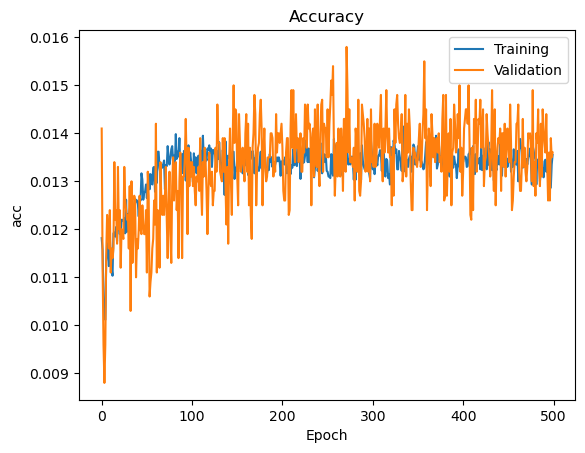

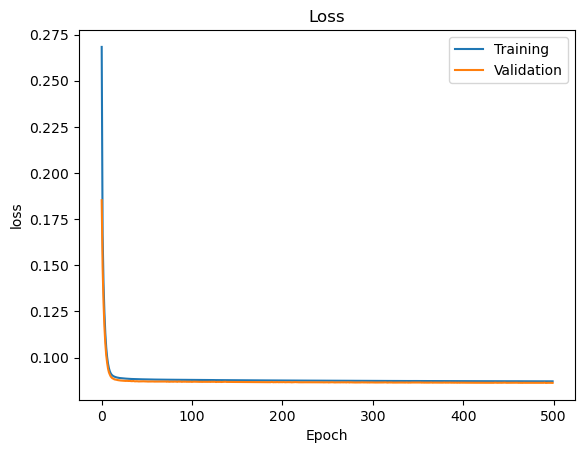

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001E15E1B3648>, <tensorflow.python.keras.layers.core.Dense object at 0x000001E15E1B3188>, <tensorflow.python.keras.layers.core.Dense object at 0x000001E15E1D0AC8>]


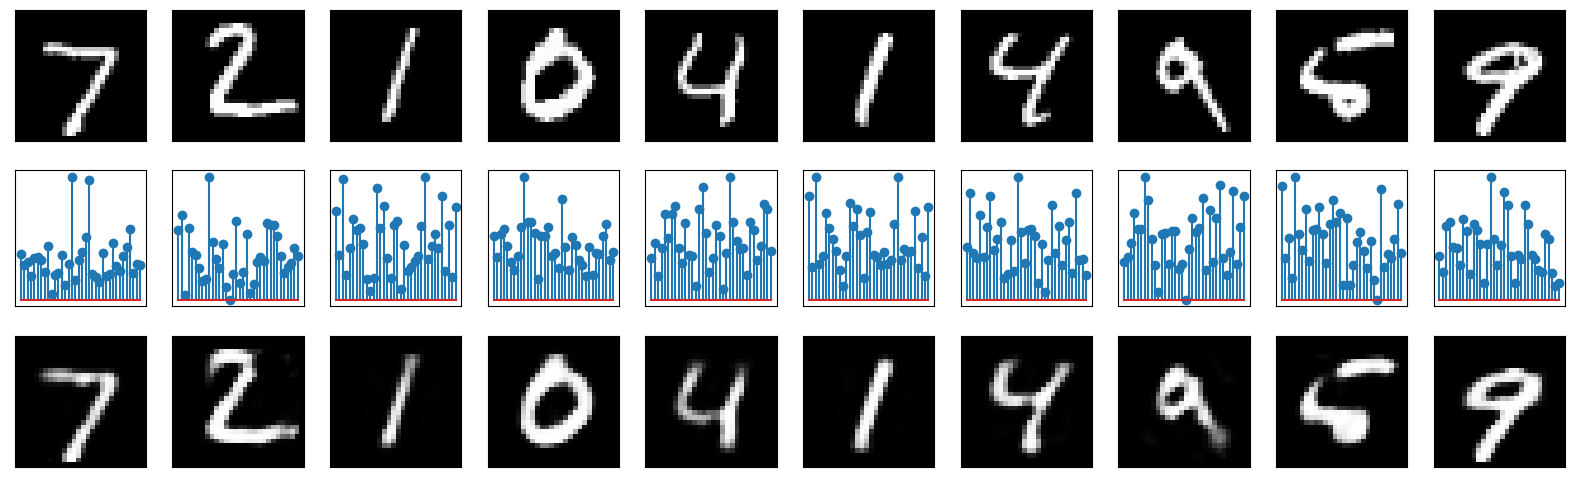

In [30]:
main()

---
### 6.2.6 전체 코드